In [1]:
import os
import sys
from pathlib import Path

from imblearn.over_sampling import SMOTE

ROOT_DIR = Path(os.getcwd()).parent.resolve()
sys.path.append(str(ROOT_DIR))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from src.config import cfg  # noqa: E402
from src.logger import get_logger  # noqa: E402

log = get_logger(__name__)

# 1. Load data

In [3]:
features_path = f"{ROOT_DIR}/{cfg['data']['features_path']}"
labels_path = f"{ROOT_DIR}/{cfg['data']['labeled_path']}"
features = pd.read_parquet(features_path)
labels   = pd.read_parquet(labels_path)

df = features.merge(labels, on="userId", how="inner")

log.info(f"Loaded dataset shape: {df.shape}")


2025-10-09 01:47:46,712 | INFO | __main__: Loaded dataset shape: (426, 37)


# 2. Prepare X, y

In [4]:
X = df.drop(columns=["userId", "churn", "last_ts_dt", "auth_fail_ratio"])
y = df["churn"].astype(int)

# Handle any non-numeric columns
X = pd.get_dummies(X, drop_first=True)

# Fill NaNs
X = X.fillna(0)

# 3. Split train / test

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 4. Scale numeric features

In [6]:
num_cols = X_train.select_dtypes(include=np.number).columns
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# 5. Handling Class Imbalanced

In [7]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print('Imbalance')
print(X_train.shape)
print(y_train.value_counts())

print('Balance')
print(X_train_smote.shape)
print(y_train_smote.value_counts())

Imbalance
(340, 84)
churn
0    285
1     55
Name: count, dtype: int64
Balance
(570, 84)
churn
0    285
1    285
Name: count, dtype: int64


# 5. Train model (RandomForest)

In [8]:
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    class_weight="balanced"
)
model.fit(X_train_smote, y_train_smote)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       random_state=42)

# 6. Evaluate

In [9]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

log.info(f"Accuracy: {acc:.3f}")
log.info(f"ROC-AUC: {auc:.3f}")
log.info(f"\nClassification report:\n {classification_report(y_test, y_pred)}")

2025-10-09 01:47:46,924 | INFO | __main__: Accuracy: 0.849
2025-10-09 01:47:46,925 | INFO | __main__: ROC-AUC: 0.830
2025-10-09 01:47:46,928 | INFO | __main__: 
Classification report:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91        72
           1       0.54      0.50      0.52        14

    accuracy                           0.85        86
   macro avg       0.72      0.71      0.71        86
weighted avg       0.84      0.85      0.85        86



# 7. Feature Importance

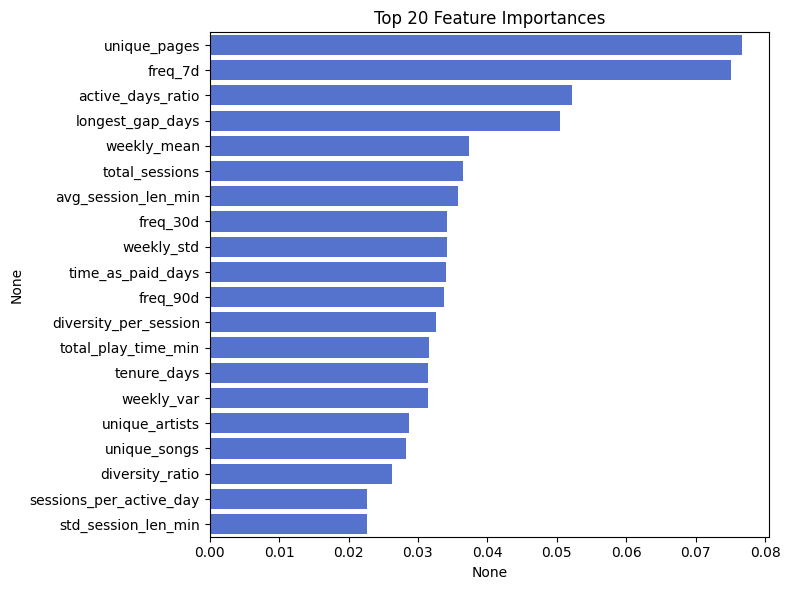

In [10]:
importances = pd.Series(model.feature_importances_, index=X_train.columns)
imp_sorted = importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
sns.barplot(x=imp_sorted, y=imp_sorted.index, color="royalblue")
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()

In [11]:
importances.sort_values(ascending=True)

region_ME                0.000000
region_ID                0.000000
region_HI                0.000000
region_AR                0.000000
signup_cohort_2018-05    0.000000
                           ...   
weekly_mean              0.037360
longest_gap_days         0.050431
active_days_ratio        0.052150
freq_7d                  0.075120
unique_pages             0.076749
Length: 84, dtype: float64